In [51]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [21]:
def f(x):
    return 3*x**2 - 4*x + 5

In [22]:
f(3.0)

20.0

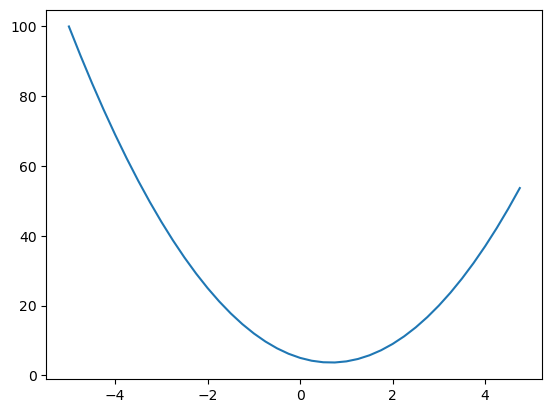

In [23]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [24]:
h = 0.000001
x = 2/3

In [25]:
(f(x + h) - f(x))/h

2.999378523327323e-06

In [26]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # no effect
        self._backward = lambda: None
        self._prev = set(_children) 
        self._op = _op
        self.label = label

    
    def __repr__(self):
        return f"Value(data={self.data}, label={self.label})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out=  Value(self.data + other.data, (self, other), "+")
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return other + (-self)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
        return out
    
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * other**-1  
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float"
        out = Value(self.data**other, (self,), f"**{other}")
        
        def _backward():
            self.grad += other * (self.data**(other-1)) * out.grad
        out._backward = _backward
        
        return out

    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1- t**2) * out.grad
            
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v): # bfs
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label ='c')
e = a*b; e.label='e'
d = e+c; d.label='d'
f = Value(-2.0, label='f')
L = d*f; L.label="L"

In [27]:
d._prev

{Value(data=-6.0, label=e), Value(data=10.0, label=c)}

In [28]:
from graphviz import Digraph

def trace(root):
    """builds a set of all nodes and edges in a graph"""
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def str_id(node):
    return str(id(node))

def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str_id(n)
        dot.node(name =uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str_id(n1), str_id(n2) + n2._op)
    return dot

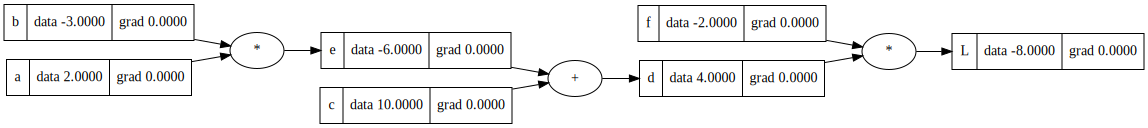

In [29]:
draw_dot(L) # tada forward pass

For back propogation we want to get the deritive of L in respect to variables. In a NN you would be interest against weights but not against dta

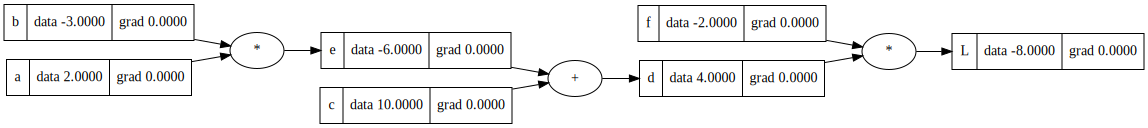

In [30]:
draw_dot(L) # add in the grad

In [31]:
def lol():
    h = 0.0001
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label ='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label="L"
    L1 = L.data
    
    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label ='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label="L"
    L2 = L.data
    
    print((L2-L1)/h)

In [32]:
lol()

6.000000000021544


In [33]:
# manual using chain rule
L.grad = 1.0
d.grad = -2.0
f.grad = 4.0
c.grad = -2.0
e.grad = -2.0
a.grad =6.0
b.grad = -4.0

In [34]:
def practice_step(a, b, c, f, step):
    # one small step
    a.data += step * a.grad
    b.data += step * b.grad
    c.data += step * c.grad
    f.data += step * f.grad

    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label="L"
    return L

In [35]:
L_manual = practice_step(a, b,c,f, 0.001)
print(L_manual)

Value(data=-7.9439519999999995, label=L)


the activation function usual is a squashing such as a signmoid or tanh

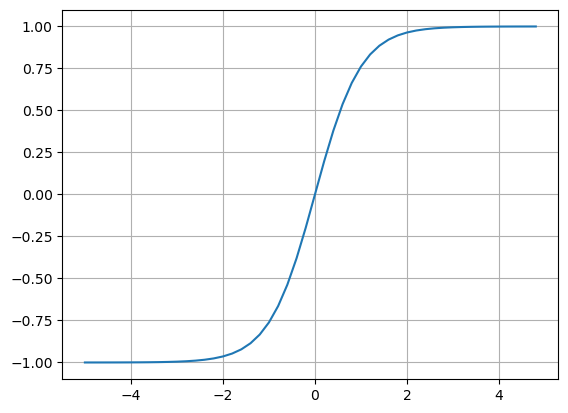

In [36]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()

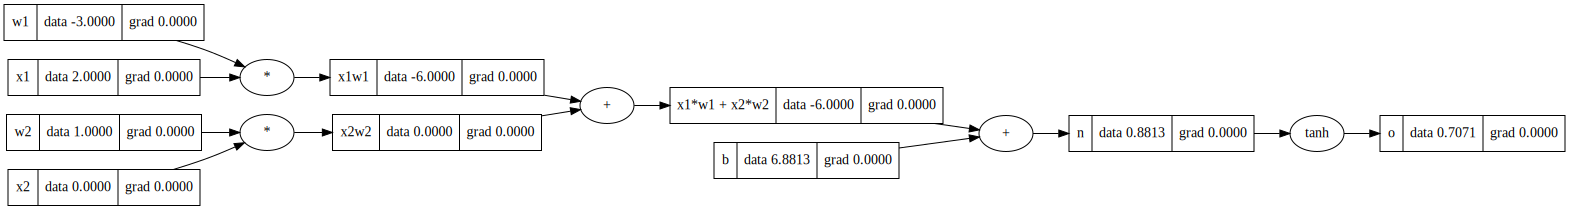

In [37]:
# manual neuron
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.881335870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'

draw_dot(o)

In [38]:
o.grad = 1.0
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()

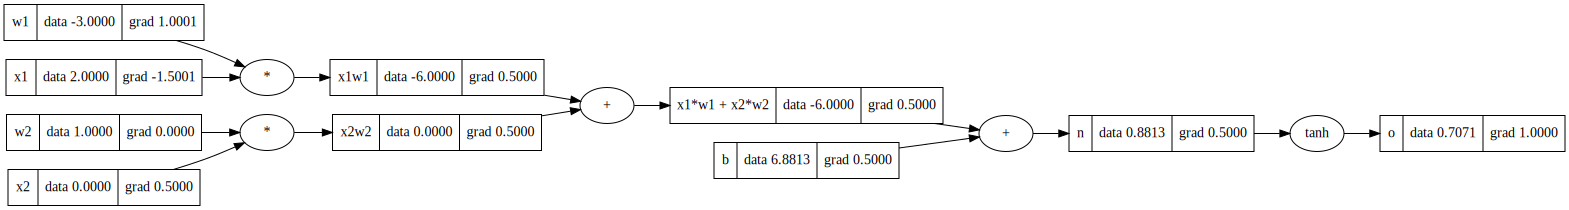

In [39]:
draw_dot(o)

In [40]:
topo = []
visited = set()
def build_topo(v): # bfs
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=0.0, label=x2),
 Value(data=1.0, label=w2),
 Value(data=0.0, label=x2w2),
 Value(data=-3.0, label=w1),
 Value(data=2.0, label=x1),
 Value(data=-6.0, label=x1w1),
 Value(data=-6.0, label=x1*w1 + x2*w2),
 Value(data=6.881335870195432, label=b),
 Value(data=0.8813358701954321, label=n),
 Value(data=0.7070879222715372, label=o)]

In [41]:
for node in reversed(topo):
    node._backward()

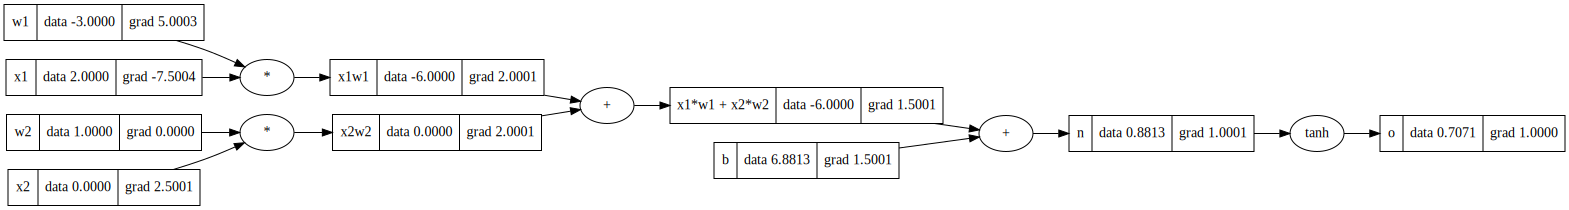

In [42]:
o.grad
draw_dot(o)

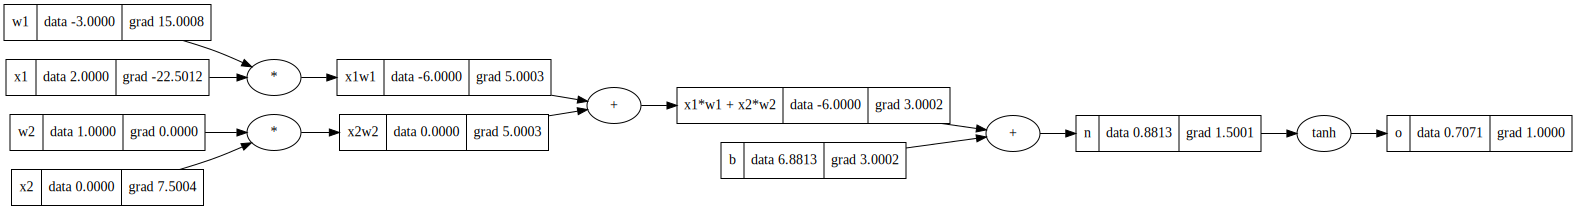

In [43]:
o.backward()
draw_dot(o)

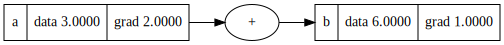

In [44]:
# bug for b = a + a
# fixed by accumlating self.grad with += instead of =
a = Value(3.0, label='a')
b = a + a; b.label='b'
b.backward()
draw_dot(b)

In [45]:
# manual neuron
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.881335870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'

#---
e = (2*n).exp()
o = (e-1) / (e+1)
o.label='o'
o.backward()

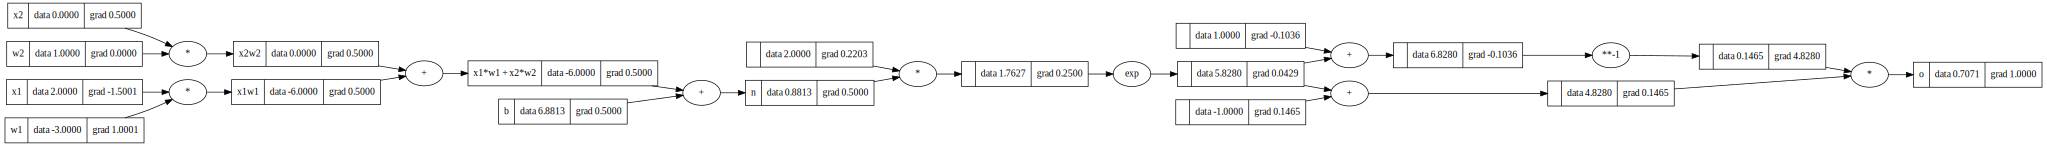

In [46]:
draw_dot(o)

 # PyTorch Version
 Now we will implment the same thing but in pytorch

In [47]:
import torch

In [48]:
x1 = torch.Tensor([2.0]).double()    ; x1.requires_grad = True #leaf node don't need gradients but in this case we do need this
x2 = torch.Tensor([0.0]).double()    ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()   ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()    ; w2.requires_grad = True
b = torch.Tensor([6.881335870195432]).double()    ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.item()) 
o.backward()

print('----')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.70708785483074
----
x2 0.5000267655508623
w2 0.0
x1 -1.500080296652587
w1 1.0000535311017247


In [49]:
torch.Tensor([[1, 2, 3], [4,5,6]]).double() 

tensor([[1., 2., 3.],
        [4., 5., 6.]], dtype=torch.float64)

In [246]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.3932111421579245, label=)

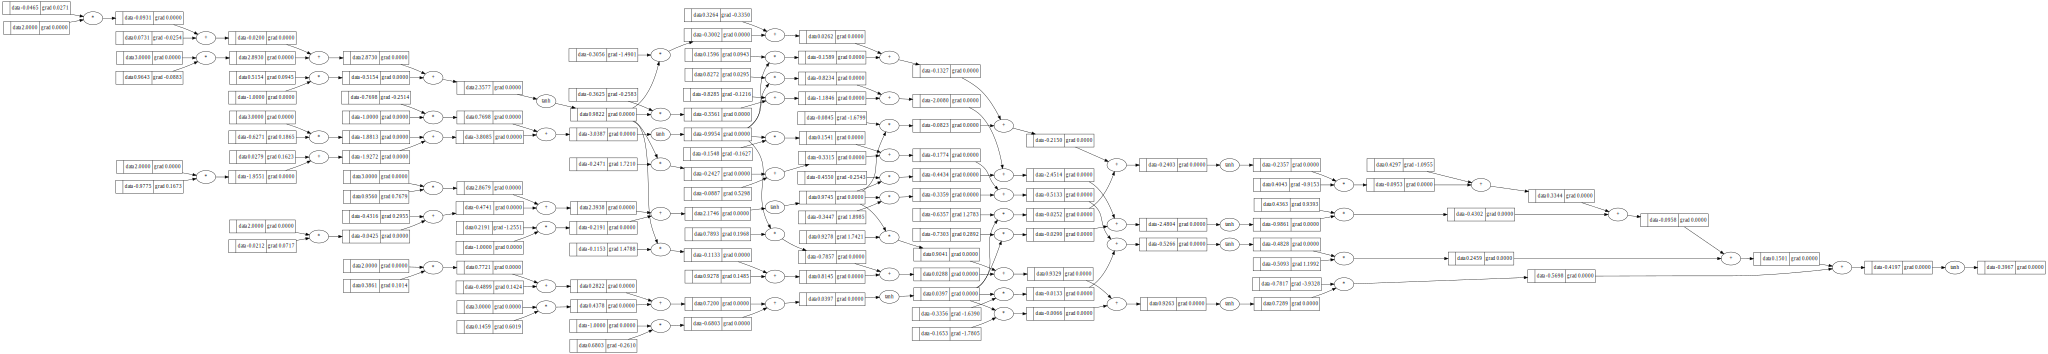

In [149]:
draw_dot(n(x))

In [242]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] #desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=1.0, label=),
 Value(data=-1.0, label=),
 Value(data=-1.0, label=),
 Value(data=1.0, label=)]

In [152]:
loss = sum([(yout-ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=3.099464745710276, label=)

In [153]:
loss.backward()

In [158]:
n.layers[0].neurons[0].w[0].grad

-0.028396956572228092

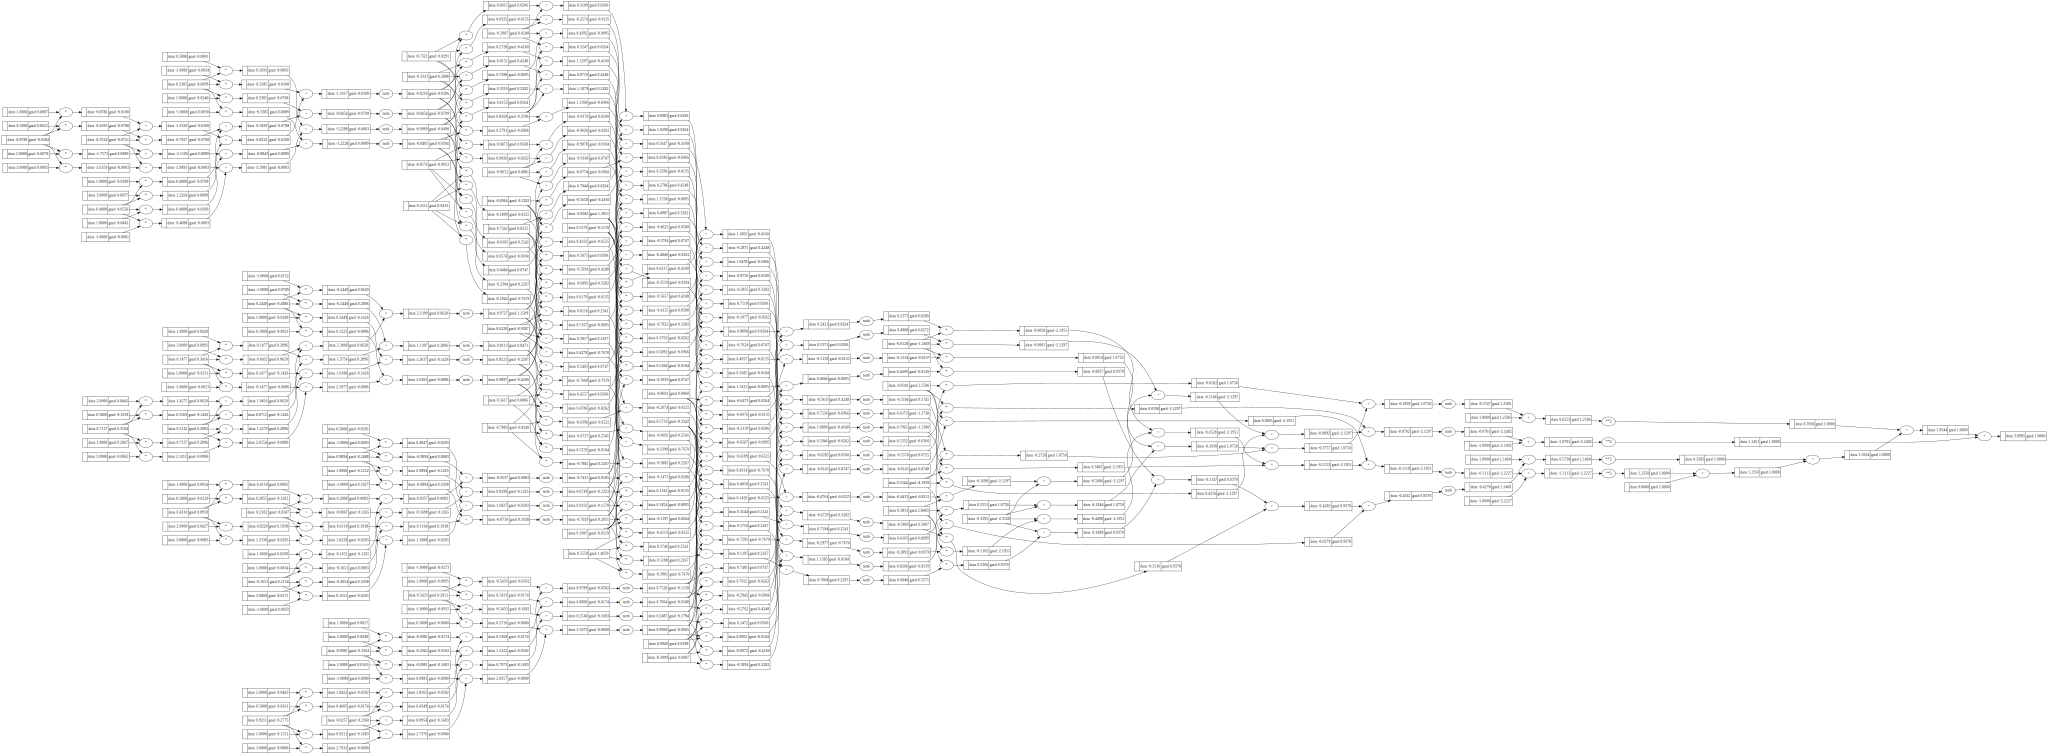

In [155]:
draw_dot(loss)

[Value(data=-0.8786300332541666, label=),
 Value(data=0.40878732513638383, label=),
 Value(data=0.33851181292876564, label=),
 Value(data=-0.3533862540748023, label=),
 Value(data=0.7137277419518702, label=),
 Value(data=0.14772117376196747, label=),
 Value(data=0.24491566865160386, label=),
 Value(data=0.5141885504729926, label=),
 Value(data=0.4109977411515331, label=),
 Value(data=-0.16513538106164183, label=),
 Value(data=0.9894131862918403, label=),
 Value(data=-0.21016950459827344, label=),
 Value(data=0.9210790361506667, label=),
 Value(data=-0.09810881621845335, label=),
 Value(data=0.5432930085120806, label=),
 Value(data=-0.025675881219038077, label=),
 Value(data=0.23108672692321708, label=),
 Value(data=-0.7883366429688365, label=),
 Value(data=0.5550439567016683, label=),
 Value(data=0.5732633321636689, label=),
 Value(data=0.6220416368148356, label=),
 Value(data=-0.7321182275771327, label=),
 Value(data=0.7241543731969426, label=),
 Value(data=0.19870741958568594, label=

In [166]:
# gradient decent
for p in n.parameters():
    p.data += -0.01 * p.grad

In [161]:
n.layers[0].neurons[0].w[0].grad

-0.028396956572228092

In [162]:
n.layers[0].neurons[0].w[0].data

-0.8783460636884443

In [227]:
ypred = [n(x) for x in xs]
loss = sum([(yout-ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=1.1329025125968098e-05, label=)

In [228]:
loss.backward()

In [229]:
# gradient decent
for p in n.parameters():
    p.data += -0.01 * p.grad

In [240]:
ypred

[Value(data=1.0, label=),
 Value(data=-1.0, label=),
 Value(data=-1.0, label=),
 Value(data=1.0, label=)]

In [247]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] #desired targets

In [272]:
for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout-ygt)**2 for ygt, yout in zip(ys, ypred)])
    
    # zero grad
    for p in n.parameters():
        p.grad = 0.0
    
    # backward pass
    loss.backward()
    
    # update
    for p in n.parameters():
        p.data += -0.1 * p.grad
    
    print(k, loss.data)

0 0.00012067479325890697
1 0.00012062867905222546
2 0.0001205825994578176
3 0.00012053655443700633
4 0.00012049054395118136
5 0.00012044456796178395
6 0.00012039862643031608
7 0.00012035271931833558
8 0.00012030684658745209
9 0.00012026100819934061
10 0.00012021520411572553
11 0.00012016943429839637
12 0.00012012369870919176
13 0.00012007799731000851
14 0.00012003233006279814
15 0.00011998669692957286
16 0.00011994109787239706
17 0.00011989553285339725
18 0.00011985000183474569
19 0.00011980450477867598


In [273]:
ypred

[Value(data=0.9953569611097508, label=),
 Value(data=-0.9946154056229422, label=),
 Value(data=-0.9948334728454208, label=),
 Value(data=0.9934762100587264, label=)]

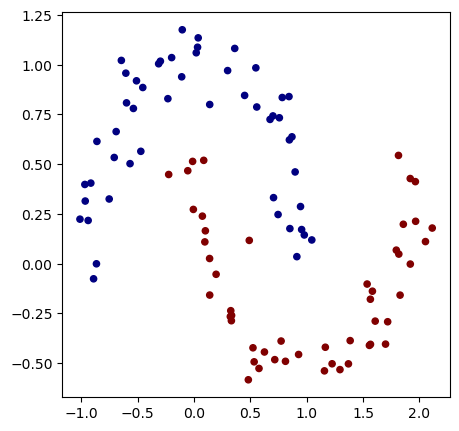

In [276]:
from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1

plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:, 1], c=y, s=20, cmap='jet')

In [279]:
# init model
model = MLP(2, [16,16,1])
print("number of parameters", len(model.parameters()))

number of parameters 337


In [282]:
def loss(batch_size=None):
    # inline DataLOader
    
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores 
    scores = list(map(model, inputs))
    losses = [(1 + -yi*scorei).tanh() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss

    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

In [283]:
total_loss, acc = loss()
print(total_loss, acc)

Value(data=0.5403662695256942, label=) 0.5


In [298]:
for k in range(100):
    # forward
    total_loss, acc = loss()
    
    # backward
    for p in model.parameters():
        p.grad = 0.0
        
    total_loss.backward()
    
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate *p.grad
        
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")
    
    

step 0 loss 0.11330583533470687, accuracy 91.0%
step 1 loss 0.1127639480404895, accuracy 91.0%
step 2 loss 0.11224245324722477, accuracy 91.0%
step 3 loss 0.111742013645821, accuracy 91.0%
step 4 loss 0.11126191324079837, accuracy 91.0%
step 5 loss 0.11080060398179681, accuracy 91.0%
step 6 loss 0.11035591472101913, accuracy 91.0%
step 7 loss 0.10992508806928344, accuracy 91.0%
step 8 loss 0.10950492134294826, accuracy 91.0%
step 9 loss 0.10909153738249855, accuracy 91.0%
step 10 loss 0.10868030760756253, accuracy 91.0%
step 11 loss 0.10826531185134147, accuracy 91.0%
step 12 loss 0.10783887192189517, accuracy 91.0%
step 13 loss 0.10739056586000535, accuracy 91.0%
step 14 loss 0.1069063664735827, accuracy 91.0%
step 15 loss 0.10636823296950865, accuracy 92.0%
step 16 loss 0.1057565529122786, accuracy 92.0%
step 17 loss 0.10505786097919416, accuracy 92.0%
step 18 loss 0.10427451001711252, accuracy 92.0%
step 19 loss 0.10342132740377782, accuracy 92.0%
step 20 loss 0.1025065883463553, ac

(-1.5837061116035573, 2.1662938883964427)

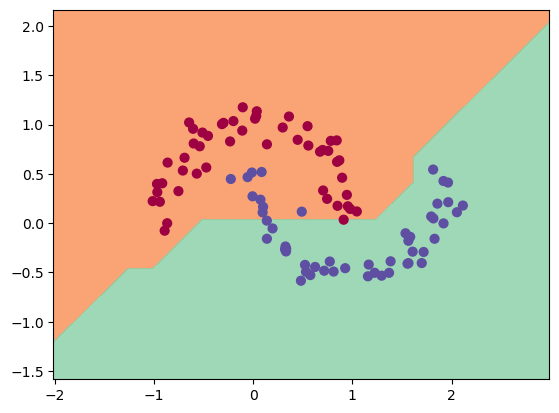

In [297]:
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
z = np.array([s.data > 0 for s in scores])
z = z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())